# Rúbrica

Review Criteria

Los criterios generales para la evaluación de la actividad son:

    Completitud del perfilamiento de datos (40 puntos)

1.1. Cantidad de registros y cantidad de columnas por tipo de dato

1.2. Significado de una fila

1.3 Estadisticas descriptivas por columna (numérica, categórica, fechas)

    Completitud del análisis de la calidad de datos (40 puntos)

2.1. Completitud: Datos que no existen o no se conocen

2.2. Unicidad: Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir

2.3. Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.

2.4 Validez: Datos correctos en el contextoCompletitud del análisis de la calidad de datos

    Conclusión del entendimiento de datos (20 puntos)

3.1. Justificación de si es posible resolver los análisis basados en tableros de control propuestos.

3.2 Incluir la síntesis de lo que representa la fila promedio de los datos analizados.

3.3 Lista de preguntas o comentarios realizados a la organización

La empresa Wide World Importers nos entrega los datos y nos dice lo siguiente:

Entendimiento de los datos de la tabla `movimientosCopia`

1. Existen 236.668 movimientos de producto realizados desde 2013
2. Los movimientos están relacionados con 228.265 clientes
3. El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
4. Actualmente tenemos 13 proveedores
5. La cantidad máxima de productos movidos es 50 millones por transacción


In [43]:
from pyspark.sql import SparkSession
from pyspark.sql import functions, DataFrame
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, sum, abs
import pyspark.sql.functions as f
import os
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport

# import matplotlib.pyplot as plt
import numpy as n

In [44]:
path_jar_driver = "/home/muniter/projects/msc/p7/datos/guias/mysql-connector.jar"
# Configuración de la sesión
conf = SparkConf().set("spark.driver.extraClassPath", path_jar_driver)

spark_context = SparkContext.getOrCreate(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession


def obtener_dataframe_de_bd(queryOrTable: str) -> DataFrame:
    # Si quiere practicar la conexion con el servidor de base de datos:
    # las credenciales están almacenadas en el keyring del sistema operativo
    import keyring
    url = keyring.get_credential("msc_analitica_mysql_db_uri", None).password
    credential = keyring.get_credential("msc_analitica_mysql_db", None)

    data = (
        spark.read.format("jdbc")
        .option("url", url)
        .option("user", credential.username)
        .option("password", credential.password)
        .option("driver", "com.mysql.cj.jdbc.Driver")
    )
    if "SELECT" in queryOrTable.upper():
        data = data.option("query", queryOrTable)
    else:
        data = data.option("dbtable", queryOrTable)

    return data.load()

In [45]:
raw_data = obtener_dataframe_de_bd("movimientosCopia")

Revisemos la descripción general de las columnas, y cuales de las afirmaciones que nos dio la empresa podemos revisar a simple vista.


In [63]:
raw_data.describe().toPandas()

,summary,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,ProveedorID,OrdenDeCompraID,FechaTransaccion,Cantidad
0,count,204292,204292,204292,204292,204292,204292,204292,204292,204292
1,mean,212458.04047637695,110.70090850351458,10.035253460732676,517.3252941867523,42957.26929590978,4.951898734177215,1345.9973277074544,None,719.4997650421946
2,stddev,71352.37579752573,63.49014746219581,0.18563716955046372,353.50136995999276,16826.9772221931,1.406311225432683,420.37740964792835,None,4729.36659747762
3,min,89146,1,10,0.0,0.0,,,2013-12-31 07:00:00.0000000,-360.0
4,max,336251,227,12,1061.0,70510.0,7.0,999.0,"Sep 30,2015",67368.0


In [47]:
(1 - (raw_data.count() / 236668)) * 100

13.679922930011656

## Descripción Inicial revisión de Afirmaciones

Este primera descripción de los datos nos permite tener una idea de cada una de las columnas, todas son numercias sin embargo por su distribución min, max y el nombre de la columna podemos afirmar lo que leemos en el diccionario que son llaves a otras tablas.

Algo que esta primera observación nos permite **ver es que hay una diferencia entre la afirmación** "1. Existen 236.668 movimientos de producto realizados desde 2013" y lo que nos muestran los datos. Pues podemos ver que tenemos un **total de 204292** filas en la tabla de movimientos. Esto representa una diferencia de 13% de datos que no obtuvimos.

Revisemos ahora los clientes, según el enunciado debemos ver 228.265 clientes. **Esto ya de por si es sospechoso pues si el total de movimientos entregados es 204 mil y una relación uno a uno con clientes y movimientos**.

In [48]:
# Count number of distinct ClienteID
raw_data.select('ClienteID').distinct().count()

664

Podemos entonces ver que solo hay 664 clientes únicos en el dataset de movimientos.

Revisemos ahora el número de proveedores, el cliente afirma que son 13:

In [62]:
raw_data.select('ProveedorID').groupBy('ProveedorID').count().orderBy('count', ascending=False).toPandas().head(10)

,ProveedorID,count
0,,197182
1,4.0,4832
2,7.0,2267
3,1.0,11


Pero claramente podemos observar que en las bases encontramos solo 3 proveedores, y que 197 mil filas tienen el ProveedorID como un dato null, lo que presenta una limitante para analizar la información de los proveedores.

Revisemos ahora el formato de las fechas, el cliente afirma "El formato de fechas manejado es YYYY-MM-DD HH:MM:SS", veamos si es cierto:

In [64]:
raw_data.select('FechaTransaccion').sample(False, 0.05, 4).toPandas().head(10)

,FechaTransaccion
0,"Jul 27,2015"
1,"Jan 29,2016"
2,"Jan 07,2016"
3,"Feb 23,2015"
4,"Jan 09,2014"
5,"Jul 04,2014"
6,"Mar 16,2015"
7,"Jan 15,2016"
8,"Dec 07,2015"
9,"Jan 26,2016"


Claramente el formato de la fecha es distinto en la muestra tomada, se utiliza un formato de fecha no recomendado para el uso en máquinas por el parsing que require. Incluso podemos ver que parece tener unas filas donde el formato es distinto. La mayoría de las filas parecen usar el formato `MMM dd, yyyy` pero parece haber unas con el formato especificado. Esto apunta a un problema de **consistencia en los datos**.

In [65]:
ft = raw_data.select('FechaTransaccion')
ft.describe().toPandas()

,summary,FechaTransaccion
0,count,204292
1,mean,None
2,stddev,None
3,min,2013-12-31 07:00:00.0000000
4,max,"Sep 30,2015"


Tratemos de convertir e identificar ambos formatos de fechas.

Haremos una conversión para cada tipo de formato que sospechamos existe y luego compararemos con los datos iniciales a ver cuantas filas quedaron con valor null.

In [72]:
dateFormat = 'MMM dd,yyyy'
withDate = raw_data.select('TransaccionProductoID', 'FechaTransaccion', f.to_date('FechaTransaccion', dateFormat).alias('FechaTransaccionDate'))
nullRows = withDate.where(f.col('FechaTransaccionDate').isNull()).count()
print("Observemos cuales son null, podemos ver es donde existe el otro formato: ")
display(withDate.where(f.col('FechaTransaccionDate').isNull()).sample(0.1).toPandas())
print(f"En total hay {nullRows} filas con un formato difrente a {dateFormat}")

Observemos cuales son null, podemos ver es donde existe el otro formato: 


,TransaccionProductoID,FechaTransaccion,FechaTransaccionDate
0,94278,2014-01-20 12:00:00.0000000,None
1,110581,2014-03-25 12:00:00.0000000,None
2,110590,2014-03-25 12:00:00.0000000,None
3,110621,2014-03-25 12:00:00.0000000,None
4,110655,2014-03-25 12:00:00.0000000,None
...,...,...,...
13923,149317,2014-08-12 12:00:00.0000000,None
13924,306684,2016-02-22 12:00:00.0000000,None
13925,93064,2014-01-15 12:00:00.0000000,None
13926,291187,2015-12-28 12:00:00.0000000,None


En total hay 140038 filas con un formato difrente a MMM dd,yyyy


In [76]:
dateTimeFormat = 'yyyy-MM-dd HH:mm:ss.SSSSSS'
withDateTime = withDate.select('*', f.to_timestamp('FechaTransaccion').alias('FechaTransaccionDateTime'))
print('Número de filas donde FechaTransaccionDateTime es null:', withDateTime.filter(f.col('FechaTransaccionDateTime').isNull()).count())
print('Esos rows se ven de la siguiente manera:')
withDateTime.where('FechaTransaccionDateTime is null').sample(0.1).show(5)

raw_data_with_fecha_parsed = withDateTime

Número de filas donde FechaTransaccionDateTime es null: 64254
Esos rows se ven de la siguiente manera:


+---------------------+----------------+--------------------+------------------------+
|TransaccionProductoID|FechaTransaccion|FechaTransaccionDate|FechaTransaccionDateTime|
+---------------------+----------------+--------------------+------------------------+
|               209857|     Mar 25,2015|          2015-03-25|                    null|
|               136914|     Jun 27,2014|          2014-06-27|                    null|
|               240543|     Jul 06,2015|          2015-07-06|                    null|
|               283020|     Nov 26,2015|          2015-11-26|                    null|
|               140035|     Jul 09,2014|          2014-07-09|                    null|
+---------------------+----------------+--------------------+------------------------+
only showing top 5 rows



Ahora agamos juntemos las dos columnas, como la FechaDeTransaccion ya parseada en una columna tipo datetime y revisemos los null, si da igual al número de filas inicial no tenemos perdidad de datos.

In [77]:
# Coalesce FechaTransaccionDate and FechaTransaccionTime into one column FechaTransaccionParsed
result = withDateTime.select('FechaTransaccion', f.coalesce('FechaTransaccionDate', 'FechaTransaccionDateTime').alias('FechaTransaccionParsed'))
if result.count() == result.where('FechaTransaccionParsed is not null').count():
    print('Después de coalesce, no hay nulos, todas las filas fueron parseadas correctamente, descripción:')
else:
    print('Después de coalesce, hay nulos, no todas las filas fueron parseadas correctamente')

Después de coalesce, no hay nulos, todas las filas fueron parseadas correctamente, descripción:


Podemos generar una gráfica de número de transacciones por mes para observar el comportamiento.

<Axes: xlabel='FechaTransaccion'>

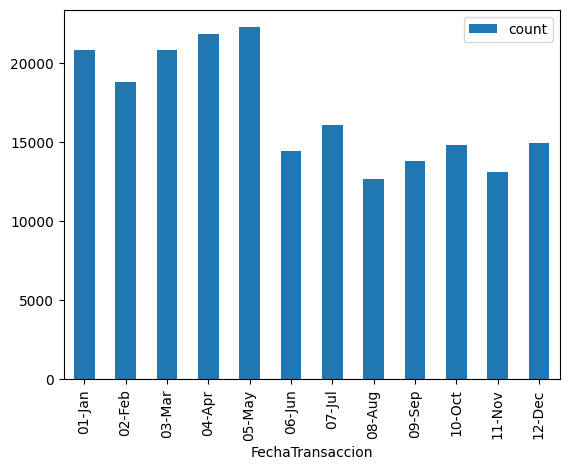

In [78]:
# Change it to a barchart
result.select(f.date_format('FechaTransaccionParsed', 'MM-MMM').alias('FechaTransaccion')).groupBy('FechaTransaccion').count().orderBy('FechaTransaccion').toPandas().plot.bar(x='FechaTransaccion', y='count')

Ahora revisemos la última afirmación del cliente que dice "La cantidad máxima de productos movidos es 50 millones por transacción". Para esto no me queda claro que es una transacción en este contexto, pues la tabla se llama movimientos, revisemos de dos formas, considerando que una transacción es una fila, o agrupando por tipo de transacción y sumando la cantidad de productos movidos.

Haremos la conversión de la columna con valor absoluto entendiendo que el movimiento puede ser de entrada o salida.

In [79]:
# Get the max value
comoFila = raw_data.select(f.abs('Cantidad').alias('CantidadABS')).rdd.max()[0]
comoTipoDeTransaccion = raw_data.select('TipoTransaccionID', f.abs('Cantidad').alias('CantidadABS')).groupBy('TipoTransaccionID').sum('CantidadABS').orderBy('sum(CantidadABS)', ascending=False).first()
print(f"Si se considera que una transaccion es una fila, el valor máximo es {comoFila}, lo cual es menor que 50 millones")
print(f"Si se considera que una transaccion es una transaccion, el valor máximo es {comoTipoDeTransaccion[1]}, para el tipo de transaccion {comoTipoDeTransaccion[0]}, que es mayor que 50 millones")

Si se considera que una transaccion es una fila, el valor máximo es 67368.0, lo cual es menor que 50 millones
Si se considera que una transaccion es una transaccion, el valor máximo es 154702496.0, para el tipo de transaccion 11, que es mayor que 50 millones


## Perfilamiento de los Datos

Además del análisis anteriormente realizado, veamos nuevamente cantidad, características de cada columna y significado de una fila.

In [82]:
display(raw_data.describe().toPandas())
raw_data.printSchema()

,summary,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,ProveedorID,OrdenDeCompraID,FechaTransaccion,Cantidad
0,count,204292,204292,204292,204292,204292,204292,204292,204292,204292
1,mean,212458.04047637695,110.70090850351458,10.035253460732676,517.3252941867523,42957.26929590978,4.951898734177215,1345.9973277074544,None,719.4997650421946
2,stddev,71352.37579752573,63.49014746219581,0.18563716955046372,353.50136995999276,16826.9772221931,1.406311225432683,420.37740964792835,None,4729.36659747762
3,min,89146,1,10,0.0,0.0,,,2013-12-31 07:00:00.0000000,-360.0
4,max,336251,227,12,1061.0,70510.0,7.0,999.0,"Sep 30,2015",67368.0


root
 |-- TransaccionProductoID: integer (nullable = true)
 |-- ProductoID: integer (nullable = true)
 |-- TipoTransaccionID: integer (nullable = true)
 |-- ClienteID: double (nullable = true)
 |-- InvoiceID: double (nullable = true)
 |-- ProveedorID: string (nullable = true)
 |-- OrdenDeCompraID: string (nullable = true)
 |-- FechaTransaccion: string (nullable = true)
 |-- Cantidad: double (nullable = true)



Como se ha mencionado antes tenemos 204292 registros, en 9 columnas con el anterior esquema, sin embargo a pesar de que en su mayoría son numéricas las columnas, realmente son categóricas.

- TransaccionProductoID: es de tipo integer, pero al ser el identificador podemos considerar que es una columna categorica.
- ProductoID: es de tipo integer, pero al ser el identificador podemos considerar que es una columna categorica.
- TipoTransaccionID: es de tipo integer, pero al ser el identificador de un tipo de la transacción podemos considerar que es una columna categorica.
- ClienteID: es de tipo integer, pero al ser el identificador podemos considerar que es una columna categorica.
- InvoiceID: es de tipo integer, pero al ser el identificador podemos considerar que es una columna categorica.
- ProveedorID: es de tipo string, debería ser tipo integer, pero al ser el identificador podemos considerar que es una columna categorica.
- OrdenDeCompraID: es de tipo string, debería ser tipo integer, pero al ser el identificador podemos considerar que es una columna categorica.
- FechaTransaccion: es de tipo string, pero realmente es una fecha, que en ocasiones también tiene el valor de la hora, como se analizó anteriormente.
- Cantidad: la cantidad es de tipo float, esta columna si es numérica, a difrenecia de las demás.

Revisemos ahora la completitud, que porcentaje de NULL hay en cada dato.

In [86]:
# Get the null percentage for each row of the dataset
df = raw_data.replace('', None)
number_of_rows = df.count()
null_counts = df.select(
    [f.sum(f.col(c).isNull().cast("int")).alias(c) for c in df.columns]
)
null_counts = null_counts.toPandas().transpose().rename(columns={0: 'count'})
null_counts['percentage'] = null_counts['count'] / number_of_rows * 100
null_counts

,count,percentage
TransaccionProductoID,0,0.000000
ProductoID,0,0.000000
TipoTransaccionID,0,0.000000
ClienteID,0,0.000000
InvoiceID,0,0.000000
ProveedorID,197182,96.519688
OrdenDeCompraID,197182,96.519688
FechaTransaccion,0,0.000000
Cantidad,0,0.000000


Podemos ver que en dos columnas, que casualmente tenían tipo string encontramos un porcentaje del 96% sin datos, esto puede indicar que son columnas que se usaron solo por un tiempo, y quedaron en el esquema de la db, pero es de suma importancia que el negocio nos indique.

Ahora revisemos unicidad.

In [87]:
full_count = raw_data.count()
distinct_count = raw_data.distinct().count()
if full_count != distinct_count:
    print(f'Hay {full_count - distinct_count} duplicados exactos (todas las columnas) son iguales')
    print(f'Porcentaje de duplicados: {(full_count - distinct_count) / full_count * 100:.2f}%')
else:
    print(f'No hay duplicados exactos (todas las columnas) en el dataset')

Hay 30633 duplicados exactos (todas las columnas) son iguales
Porcentaje de duplicados: 14.99%


Claramente tenemos problemas de unicidad, con un 15% de duplicados. Es preocupante que no se maneje un primari key con `TransaccionProductoID`` que habría eliminado este problema. Ahora miremos si encontramos quizás una duplicidad semántica, quizás movimientos con el mismo producto, tipo de transaccion, cliente e invoice en la misma fecha puedan indicar una duplicidad.

Sin embargo debido a la falta de consistencia en la fecha de transacción puede ser difícil pues unos tienen resolución hasta el segundo y otros solo hasta el día.

In [89]:
df = raw_data
result = df.groupBy('ProductoID', 'Cantidad', 'ClienteID', 'InvoiceID', 'FechaTransaccion').count().orderBy('count', ascending=True)
print('Cantidad de registros con posible duplicidad semántica: ', result.where('count > 1').count())
print('Algunos ejemplos:')
result.where('count > 1').sample(False, 0.01).toPandas()

Cantidad de registros con posible duplicidad semántica:  30633
Algunos ejemplos:


,ProductoID,Cantidad,ClienteID,InvoiceID,FechaTransaccion,count
0,84,-36.0,1018.0,41822.0,2015-02-19 12:00:00.0000000,2
1,75,-1.0,975.0,38664.0,2014-12-25 12:00:00.0000000,2
2,112,-3.0,852.0,29299.0,2014-07-09 12:00:00.0000000,2
3,183,-75.0,66.0,58558.0,2015-11-14 12:00:00.0000000,2
4,64,-1.0,107.0,27431.0,2014-06-07 12:00:00.0000000,2
...,...,...,...,...,...,...
318,98,-36.0,959.0,67056.0,2016-04-08 12:00:00.0000000,2
319,106,-7.0,186.0,22673.0,2014-03-14 12:00:00.0000000,2
320,137,-8.0,572.0,54113.0,2015-09-04 12:00:00.0000000,2
321,23,-8.0,33.0,48060.0,2015-05-29 12:00:00.0000000,2


Podemos ver que parece haber duplicidad semántica en mútliples movimientos, con varias columnas que juntas deberían quizás ser diferenciadoras del movimiento.

En este proceso también se encontraron valores llamativos en las columnas, como algunas presentando valor de 0, que para casi ninguna de las columnas tiene sentido (**falta de consistencia**), miremos:

In [94]:
with_zero = raw_data.select([
    (f.sum((f.col(c) == f.lit(0)).cast('int'))).alias(c) for c in ['Cantidad', 'ClienteID', 'InvoiceID']
])
with_zero.toPandas().transpose().rename(columns={0: 'Filas con valor de 0'})

,Filas con valor de 0
Cantidad,5
ClienteID,7156
InvoiceID,7156


Esto nos presenta más problemas de consistencia, pues aunque no son null, estos estados son inválidos:

- Un movimiento con cantidad 0 no tiene sentido.
- El hecho de que halla la misma cantidad con ClienteID 0 y InvoiceID 0 indica que es un posible placeholder cuando en realidad no se tiene dato, y no parece que fuese lo que debería ser que es un primary key.

### Fila

Una fila en este dataset representa un movimiento de un producto, este movimiento está asociada con varias entidades del negocio, un producto, un cliente, un invoice (cotización), un proveedor, una orden de compra, un tipo de transacción, una cantidad y una fecha del movimiento. Es decir trata de **representar como sale y entra un producto en el negocio**. Algo que es muy importante para una empresa de retail.

## Preguntas y aclaraciones


1. A que se debe la diferencia entre la cantidad de movimientos mencionados en el documento entregado vs lo que encontramos en el dataset (13% menos).
1. Se menciona una existencia de 228.265 clientes, al seguir la definición del diccionario en la tabla movimientos vemos se refiere a la columna `ClienteID` pero al hacer una distinción encontramos que solo hay 664 clientes distintos. ¿A que se debe esta diferencia?
1. Se meciona que la fecha está en formato `YYYY-MM-DD HH:MM:SS` (2014-01-01 10:55) pero al revisar el dataset encontramos que la columna `Fecha` está en formato `MMM dd,yyy` (Jan 01,2014) y en formato `yyyy-MM-dd HH:mm:ss.SSSSSS`. ¿A que se debe esta diferencia? Se acalara que hay más de 60 mil filas que tienen el formato sin hora.
1. Se menciona que hay 13 proveedores, pero al revisar los datos solo encontramos 3 proveedores, y 197 mil filas sin proveedor, es decir casi todo el dataset (96%). A que se debe esta diferencia, creen que se puede subsanar?
1. Al igual que con los proveedores parece haber problemas con el dato de OrdenDeCompraID, para los cuales no hay informacióñ para 197 mil filas, la misma cantidad que en el caso de ProveedorID
1. A que se refiere con "cantidad máxima de productos movidos por transacción", a una fila o la agrupación por `TipoTransacciónID`?
1. Se evidencian duplicados exactos en el dataset de un 15% lo que equivale a 30 mil filas, a que se debe esto?
1. Se evidencian ordenes con cantidad de 0, algo que debe ser imposible, que se hace con esos casos?
1. Se evidencian que el ClienteID y InvoiceID tienen valor de 0 en 7156 movimientos, realmente parecieran ser usados como placeholder para el valor NULL, que se sugiere que se haga en este caso.

## Conclusión

El dataset entregado es amplio e importante, sin embargo se detectan a simple vistas problemas de calidad, desde la unicidad a la consistencia. Esto es una primera alerta para la empresa, que sus datos relacionales tienen problemas.

Analizando que el objetivo del cliente es el siguiente:

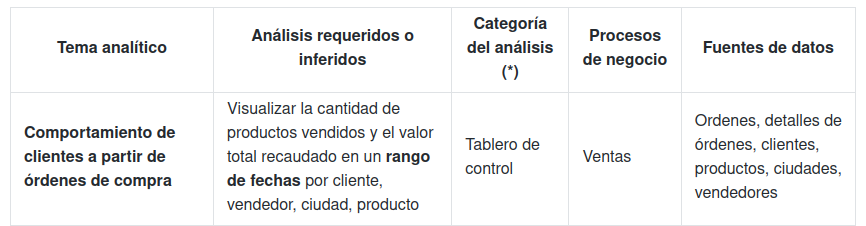

Considero que se puede alcanzar, sin embargo se debe tener presente que el dataset tiene problemas de unicidad e integridad, por lo cual los valores finales pueden ser diferentes a los esperados, y ciertos análisis no se podrán realizar. También cabe afirmar que es necesario que se provea la información relacionada a valores del producto, clientes, ciudades, etc. Pues en el dataset entregado se tienen los ID pero no sabemos si estos existen en otro dataset y que mantinene su integridad.

Sin embargo considero que se debe descartar el análisis de proveedor y orden de compra, pues no se tiene información de estos, y no se puede hacer un análisis de los mismos.